In [1]:
# Lots of this code is taken from https://nicschrading.com/project/Intro-to-NLP-with-spaCy/

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import jaccard_similarity_score

from scipy import stats

from nltk import sent_tokenize
from nltk.corpus import stopwords

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import string
import spacy

parser = spacy.load('en')

# A custom stoplist
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + \
          ["-----", "---", "...", "“", "”", "'", "'s"]

In [2]:
# Every step in a pipeline needs to be a "transformer". 
# Define a custom transformer to clean text using spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [3]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # import a dictionary of English contractions from another file
    from contractions import english_contractions
    contraction_dict = english_contractions()

    # replace the contractions with their expanded form
    for contraction, expansion in contraction_dict.items():
        text = text.replace(contraction.lower(),expansion.lower())
    
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")

    # lowercase
    text = text.lower()

    return text

In [4]:
# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() 
                      if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    
    return tokens

In [5]:
# extract reviews from the json file

def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

reviews_df = getDF('web_app/data/reviews_Electronics_5_first1000.json')
reviews_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [6]:
dbname   = 'amazon_reviews'
username = 'plestran' 
engine   = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [30]:
test_asin = 'B0019EHU8G'
#test_asin = '0972683275'
con = psycopg2.connect(database = dbname, user = username)
sql_query = """
    SELECT * FROM reviews
     WHERE asin = '%s';
    """ % test_asin
test_df = pd.read_sql_query(sql_query,con)
test_df = test_df.replace('', np.nan)
test_df = test_df.dropna()

In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3434 entries, 0 to 3434
Data columns (total 10 columns):
index             3434 non-null int64
reviewerID        3434 non-null object
asin              3434 non-null object
reviewerName      3434 non-null object
helpful           3434 non-null object
reviewText        3434 non-null object
overall           3434 non-null float64
summary           3434 non-null object
unixReviewTime    3434 non-null int64
reviewTime        3434 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 295.1+ KB


In [32]:
def define_model(df, n_topics=10, n_top_words = 3):
    # define the number features, topics, and how many 
    # words/documents to display later on
    n_features      = 1000
    n_top_documents = min(int(df['reviewText'].size/2),10)

    # Use tf-idf vectorizer
    vectorizer = TfidfVectorizer(max_features=n_features,
                                 tokenizer=tokenizeText,
                                 stop_words='english', 
                                 ngram_range=(1,2),
                                 max_df=0.9, min_df=3)

    # use NMF model with the Frobenius norm
    clf = NMF(n_components=n_topics, random_state=1, 
              solver='mu', beta_loss='frobenius')

    # put it all in a pipeline
    pipe = Pipeline([('cleanText', CleanTextTransformer()), 
                     ('vectorizer', vectorizer), 
                     ('nmf', clf)
                    ])
    
    return vectorizer, clf, pipe, n_top_words, n_top_documents

vectorizer, clf, pipe, n_top_words, n_top_documents = define_model(test_df, n_topics=6)

In [33]:
# Fit the model
pipe.fit(test_df['reviewText']);

In [34]:
# grab term-document matrix
transform = pipe.fit_transform(test_df['reviewText'])

In [35]:
X  = vectorizer.fit_transform(test_df['reviewText']).toarray()

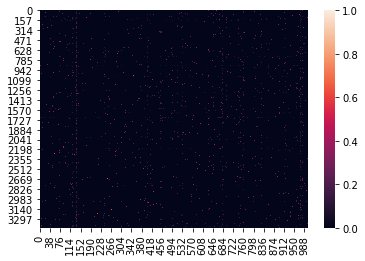

In [36]:
ax = sns.heatmap(X)

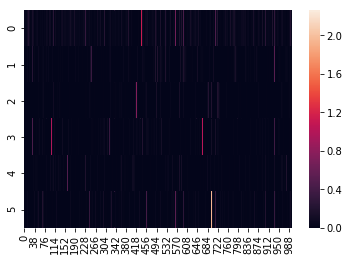

In [37]:
ax = sns.heatmap(clf.components_)

In [38]:
clf.reconstruction_err_

55.50713481373762

In [39]:
def display_topics(vectorizer, clf, W, df, n_top_words, n_top_documents):
    ''' Print out topics discovered by a model '''
    
    # get list of feature names
    feature_names = vectorizer.get_feature_names()
    
    # get VADER sentiment analyzer
    analyser      = SentimentIntensityAnalyzer()    
    
    # list of topics and reviews to return
    topics, reviews = [], []
    
    # loop over all the topics
    for topic_id, topic in enumerate(clf.components_):
        
        # grab the list of words describing the topic
        word_list = []
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            word_list.append(feature_names[i])
        
        # split words in case there are some bigrams and get unique set
        split_list = []
        for word in word_list:
            for split in word.split():
                split_list.append(split)
        topic_words = list(set(split_list))
        
        # append topic words as a single string
        topics.append(' '.join([word for word in topic_words]))
        
        # print topic number and topic words
        print('Topic #%02d: %s' % (topic_id+1, topics[-1]))

        # loop over reviews for each topic
        top_doc_indices = np.argsort( W[:,topic_id] )[::-1][0:n_top_documents]
        for doc_index in top_doc_indices:

            # check that the review contains one of the topic words
            if any(word in df['reviewText'].iloc[doc_index].lower() for word in topic_words):
                
                # sentiment analysis
                vader = analyser.polarity_scores(df['reviewText'].iloc[doc_index])
                
                # append current review to the list 
                reviews.append(df.iloc[doc_index].to_dict())
                reviews[-1]['topic']       = topic_id
                reviews[-1]['topic_words'] = ' '.join([word for word in topic_words])
                reviews[-1]['sentiment']   = vader['compound']
                
                print('User %20s on %s with rating %s' % (df['reviewerName'].iloc[doc_index][:20], 
                                     df['reviewTime'].iloc[doc_index], df['overall'].iloc[doc_index]))            
                print("VADER: %f" % vader['compound'])
                print(reviews[-1]['reviewText'])
            else:
                print("WARNING: TOPIC NOT IN DOCUMENT")
            
        print()
        
    return topics, reviews

topics, reviews = display_topics(vectorizer, clf, transform, 
                                 test_df, n_top_words, n_top_documents)

Topic #01: hdmi cable
User         C. R. Jacobs on 11 21, 2010 with rating 5.0
VADER: 0.995600
I recently upgraded to Sony Bravia LED, Denon AV receiver and Sony BluRay.  Before now, I never had the need for any HDMI cables.  I was very skeptical about buying a less known and lower priced cable.  Most of the time...the old "you get what you pay for" holds true.  This is the exception!  I did a lot of reading on the subject first.  Plenty of opinions.  Some say spend the big bucks on the Monster HDMI.  Others say don't.  Consumer reports suggested that spending the extra money on higher priced HDMI cables was not necessary.  As long as the cable was well constructed and supported the type of signal you were after, it would either carry it or it wouldn't.  Simplistic way of looking at it, but seemed to make sense.I then made a trip to Best Buy.  A nice fellow that claimed to be an expert on these types of things tried his best to get me to spend $129 on a ten foot Monster HDMI cable.  Be

In [40]:
topics

['hdmi cable',
 'work great tv',
 'price great',
 'ray player blu',
 'good quality buy',
 'recommend mediabridge product']

In [41]:
# extract relevant sentences from a review for this topic
# do sentiment analysis just for those sentences
analyser = SentimentIntensityAnalyzer() 
for i, review in enumerate(reviews):
    summary     = []
    sentences   = sent_tokenize(review['reviewText'])
    topic_words = topics[review['topic']].split()
    for sentence in sentences:
        if any(word in sentence.lower() for word in topic_words):
            highlighted_sentence = '<span style="background-color: #FFFF00">'+sentence+'</span>'
            summary.append(highlighted_sentence)
        else:
            summary.append(sentence)
        
#        if any(word in sentence.lower() for word in topic_words):
#            summary.append(sentence)

    # save info for summarized reviews
    reviews[i]['summarized_reviewText'] = ' '.join([sent for sent in summary])
    vader = analyser.polarity_scores(reviews[i]['summarized_reviewText'])
    reviews[i]['summary_sentiment']      = vader['compound']
    
    # add html for user rating
    rating_html = ''
    rating = int(reviews[i]['overall'])
    for _ in range(rating):
        rating_html += '<span class="fa fa-star checked"></span>'
    for _ in range(rating,5):
        rating_html += '<span class="fa fa-star"></span>'
    reviews[i]['overall_html'] = rating_html
    
    # print information
    print(topic_words, review['reviewerName'])
    print(reviews[i]['reviewText'])
    print("\n")
    print(reviews[i]['summarized_reviewText'])
    print("Vader: %f\n" % vader['compound'])
    

['hdmi', 'cable'] C. R. Jacobs
I recently upgraded to Sony Bravia LED, Denon AV receiver and Sony BluRay.  Before now, I never had the need for any HDMI cables.  I was very skeptical about buying a less known and lower priced cable.  Most of the time...the old "you get what you pay for" holds true.  This is the exception!  I did a lot of reading on the subject first.  Plenty of opinions.  Some say spend the big bucks on the Monster HDMI.  Others say don't.  Consumer reports suggested that spending the extra money on higher priced HDMI cables was not necessary.  As long as the cable was well constructed and supported the type of signal you were after, it would either carry it or it wouldn't.  Simplistic way of looking at it, but seemed to make sense.I then made a trip to Best Buy.  A nice fellow that claimed to be an expert on these types of things tried his best to get me to spend $129 on a ten foot Monster HDMI cable.  Because he would not stop talking about his expertise on the subje

In [42]:
reviews_df = pd.DataFrame(reviews)
reviews_df.to_csv('%s_reviews.csv' % test_asin,index=False)
reviews_df.head()

,asin,helpful,index,overall,overall_html,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summarized_reviewText,summary,summary_sentiment,topic,topic_words,unixReviewTime
0,B0019EHU8G,"{2,2}",16023,5.0,"<span class=""fa fa-star checked""></span><span ...","I recently upgraded to Sony Bravia LED, Denon ...","11 21, 2010",AWUMHJEOQOS33,C. R. Jacobs,0.9956,"I recently upgraded to Sony Bravia LED, Denon ...",Excellent,0.9946,0,hdmi cable,1290297600
1,B0019EHU8G,"{0,0}",17103,5.0,"<span class=""fa fa-star checked""></span><span ...",This is a great HDMI cable. This is but one o...,"06 9, 2012",A3INMIZIYJ9BQ4,"Judi Fryer ""Judi, Entertainment-glutton""",0.9480,"<span style=""background-color: #FFFF00"">This i...",GREAT CABLE,0.9480,0,hdmi cable,1339200000
2,B0019EHU8G,"{0,0}",16154,5.0,"<span class=""fa fa-star checked""></span><span ...",I bought these Mediabridge Ultra Series Cables...,"07 20, 2012",A2872G6D9GENQH,Deckard7,0.9480,"<span style=""background-color: #FFFF00"">I boug...",Mediabridge Ultra Series HDMI Cables,0.9480,0,hdmi cable,1342742400
3,B0019EHU8G,"{483,613}",16377,2.0,"<span class=""fa fa-star checked""></span><span ...","Comparative Results: Technically Average, Over...","05 27, 2009",A2Y5T1O43P14RP,"Eliezer Kolatch ""Ez""",0.9910,"<span style=""background-color: #FFFF00"">Compar...","Comparative Results: Technically Average, Over...",0.9888,0,hdmi cable,1243382400
4,B0019EHU8G,"{0,0}",18129,5.0,"<span class=""fa fa-star checked""></span><span ...",A well made HDMI cable with secure insertion /...,"11 19, 2012",A1KOFMBPD28KSH,Ron Reed,0.9259,"<span style=""background-color: #FFFF00"">A well...",Does the job,0.9259,0,hdmi cable,1353283200


In [43]:
#------------------------------------------------------------------
def unique(sequence):
    '''get unique elements of list and keep the same order'''
    
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]
#------------------------------------------------------------------

reviews = pd.read_csv('0972683275_reviews.csv')
topics = unique(reviews['topic_words'])
topics

['mount wall tv',
 'work great',
 'install easy',
 'good price buy',
 'stud plate screw',
 'flat mount monitor']

In [44]:
reviews = list(reviews.T.to_dict().values())

# Measuring Redundancy

In [48]:
topic_words = ' '.join(topic for topic in topics)
print(topic_words)

tv mount wall great work install easy good price buy plate stud screw flat monitor mount


In [35]:
def max_entropy(n):
    return -np.log(1/n)

def redundancy(string):
    entropy, string_list = 0, string.split()
    string_set = unique(string_list)
    for word in string_set:
        p = string_list.count(word)/len(string_list)
        entropy -= p*np.log(p)        
    return 1 - entropy/max_entropy(len(string_list))

In [36]:
def lemmatize(string):
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
    tokens = parser(string)
    lemmas = []
    for token in tokens:
        lemmas.append(stemmer.stem(token.lemma_.lower().strip()))
        
    return ' '.join(lemma for lemma in lemmas)

string = 'install mounting inch mounted screws stud installation installed instructions mounts move hardware holes bolts bedroom plate samsung'
lemmas = lemmatize(string) 
print(lemmas)
print(redundancy(lemmas))

instal mount inch mount screw stud instal instal instruct mount move hardwar hole bolt bedroom plate samsung
0.13685715354299643


In [37]:
redundancy('word word word word')

1.0

In [233]:
dbname   = 'amazon_reviews'
username = 'plestran' 
engine   = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

postgres://plestran@localhost/amazon_reviews
True


In [235]:
# Connect to make queries using psycopg2
con = psycopg2.connect(database = dbname, user = username)

In [226]:
keyword_df = pd.read_csv('asin_keywords/asin_keywords.txt.1')
keyword_df.head()

,asin,keywords
0,B003WGNPKQ,stands spring wide tall base studio softbox va...
1,B005EN83A2,keys space type typing cases hinge key clam ba...
2,B0033WSDO2,running quiet video gpu system driver install ...
3,B002CQU14A,paste cpu temps silver cooler apply arctic hea...
4,B0098QTFTO,tablet holds mounting spring securely tension ...


In [389]:
def retrieve_concise_topics(vectorizer, clf, n_top_words):
    ''' Retrieve topics discovered by a model '''
    
    # get list of feature names
    feature_names = vectorizer.get_feature_names()
    
    # get VADER sentiment analyzer
    analyser      = SentimentIntensityAnalyzer()    

    topics = []
    # loop over all the topics
    for topic_id, topic in enumerate(clf.components_):
    
        # grab the list of words describing the topic
        word_list = []
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            word_list.append(feature_names[i])
        
        # split words in case there are some bigrams and get unique set
        split_list = []
        for word in word_list:
            for split in word.split():
                split_list.append(split)
            topic_words = list(set(split_list))
        
        # append topic words as a single string
        topics.append(' '.join([word for word in topic_words]))

    return topics

In [394]:
# loop over asin in db and check redundancy
keywords_dict = list(keyword_df.T.to_dict().values())
amazon_red, nmf_red, count = [], [], 0
amazon_key, nmf_key = [], []
for i_asin, keyword in enumerate(keywords_dict):

    # grab reviews for current product
    sql_query = """
    SELECT * FROM reviews
     WHERE asin = '%s';
    """ % keyword['asin']
    product_df = pd.read_sql_query(sql_query,con)

    # check that we have enough reviews
    if len(product_df['reviewText']) > 20:
        count += 1
    
        # fit the model and return topics
        vectorizer, clf, pipe, n_top_words, n_top_documents = define_model(product_df,n_topics=6)
        pipe.fit(product_df['reviewText'])
        topics = retrieve_concise_topics(vectorizer, clf, n_top_words)
        topic_string = ' '.join(topic for topic in topics)
    
        # measure redundancy for Amazon's keywords and my topics
        amazon_red.append(redundancy(lemmatize(keyword['keywords'])))
        nmf_red.append(redundancy(topic_string))
        amazon_key.append(keyword['keywords'])
        nmf_key.append(topic_string)
        print("ASIN #%d: Amazon: %4.2f, NMF: %4.2f" % ( i_asin,
                                                        redundancy(lemmatize(keyword['keywords'])), 
                                                        redundancy(topic_string) ) )
        print("Amazon: %s" % keyword['keywords'])
        print("NMF: %s\n" % topic_string)

#print("Amazon: %6.4f, NMF: %6.4f" % (amazon_red/count, nmf_red/count))

ASIN #0: Amazon: 0.00, NMF: 0.00
Amazon: stands spring wide tall base studio softbox value umbrella metal loaded durable heavier release stable locks shoot screw tighten legs
NMF: light stand recommend support buy hold need like feel duty heavy really easy base strong cheap clamp

ASIN #3: Amazon: 0.07, NMF: 0.06
Amazon: paste cpu temps silver cooler apply arctic heat tube gpu load temperature degrees idle applied temperatures performance stock temp 
NMF: compound thermal use thermal paste easy arctic 5 sink heat like stuff use stock tube cooler

ASIN #10: Amazon: 0.03, NMF: 0.02
Amazon: door manual wireless plugged front talk signal dark security instructions system cameras setup plug range website button bed  
NMF: vision monitor night nice door use unit manual product audio pan tilt set easy manual download online feature really lcd

ASIN #11: Amazon: 0.03, NMF: 0.06
Amazon: headphones cable zipper pouch pro velcro cord solid protects protect smell outside strap space snug backpack 

ASIN #80: Amazon: 0.05, NMF: 0.03
Amazon: laptop compartment carry lenses straps pack gear pocket flash lens equipment travel space carrying accessories canon memory nikon  
NMF: camera bag carry adventure pocket compartment strap pack load secure backpack storage canon mm compartment build product great

ASIN #82: Amazon: 0.03, NMF: 0.03
Amazon: pictures video underwater waterproof cameras taking taken photos trip beach manual settings lens shoot memory computer features   
NMF: picture good battery picture great waterproof water warranty time buy easy use place usb include zoom shot issue

ASIN #83: Amazon: 0.05, NMF: 0.06
Amazon: lights photo pictures tripod photos lighting items setup folds jewelry bulbs taking kit bright stand background included value lamps 
NMF: light white box like fold case bulb light picture decent quality tripod buy easy tripod product recommend

ASIN #84: Amazon: 0.02, NMF: 0.03
Amazon: cards speed shoot raw shots memory canon faster reliable pictures flash

ASIN #144: Amazon: 0.05, NMF: 0.03
Amazon: space dvds sleeve movies disc insert thin collection paper standard discs save covers artwork packaging spine inserts shelf label 
NMF: dvd case slip cover dvds movie collection recommend disc hold save space case cheap buy order

ASIN #147: Amazon: 0.08, NMF: 0.05
Amazon: comcast mac pay address rental router company install call docsis speed refurb called renting speeds internet provider installed  
NMF: cable modem router good price modem month pay 6 docsis support seller problem month rent far deal 30

ASIN #149: Amazon: 0.02, NMF: 0.03
Amazon: mic headphones microphone ear headsets volume ears audio cord sounds noise hear skype bass games usb decent voice comfort mute
NMF: mic headset use great sound sound quality noise good headphone ear way buy like plantronics audio

ASIN #150: Amazon: 0.07, NMF: 0.10
Amazon: pictures photos features cameras shoot shots pics taking shot card feature settings video memory computer photo pocket focus opt

ASIN #242: Amazon: 0.02, NMF: 0.04
Amazon: galaxy storage cards tablet micro write space note data microsd videos capacity speeds advertised files video sandisk test android 
NMF: sd card read mb write gb 32 note galaxy good price memory galaxy samsung

ASIN #245: Amazon: 0.09, NMF: 0.00
Amazon: protection zipper computer laptop snug protect pro tight opening backpack padded cases snugly padding carry mba protected scratch  
NMF: like sleeve air fit case good laptop product backpack close slide scratch edge macbook buy feel computer love

ASIN #248: Amazon: 0.00, NMF: 0.03
Amazon: height laptop batteries wireless wheel feature usb running button windows software macbook mice setup switch connection scroll smooth  
NMF: bluetooth usb use turn buy work make really notebook feature easy wheel laptop run time rechargeable use battery

ASIN #251: Amazon: 0.05, NMF: 0.05
Amazon: bass ear headphone noise ears comfort listening sounds cord listen flat volume lightweight hear earbuds block low 

In [398]:
print(stats.describe(amazon_red))
print(stats.describe(nmf_red))
print(len(nmf_red))

DescribeResult(nobs=93, minmax=(0.0, 0.1546742510079947), mean=0.04865390999216903, variance=0.0010533384857412315, skewness=0.8661411019740397, kurtosis=0.8779137900342455)
DescribeResult(nobs=93, minmax=(0.0, 0.13685715354299655), mean=0.041578894466142435, variance=0.0009705712337330718, skewness=0.5507401872779252, kurtosis=-0.18536644732597773)
93


DescribeResult(nobs=93, minmax=(-0.10554511722130411, 0.11512966687916515), mean=0.007075015526026604, variance=0.002252298693848945, skewness=0.11291540572708969, kurtosis=0.1022952144067748)

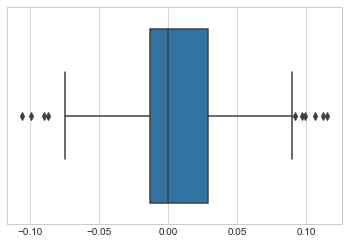

In [396]:
sns.set_style("whitegrid")
diff = [a-n for a,n in zip(amazon_red,nmf_red)]
ax = sns.boxplot(x=diff)
stats.describe(diff)

# Determine Appropriate Number of Topics

In [51]:
def retrieve_topics(vectorizer, clf, n_top_words):
    ''' Retrieve topics discovered by a model '''
    
    # get list of feature names
    feature_names = vectorizer.get_feature_names()
    
    # get VADER sentiment analyzer
    analyser      = SentimentIntensityAnalyzer()    
    
    # list of topics and reviews to return
    topics = []
    
    # loop over all the topics
    for topic_id, topic in enumerate(clf.components_):
        
        # grab the list of words describing the topic
        word_list = []
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            word_list.append(feature_names[i])
        topics.append(word_list)

    return topics

topics = retrieve_topics(vectorizer, clf, n_top_words)
print(topics)

[['cable', 'hdmi', 'hdmi cable'], ['work', 'tv', 'work great'], ['great', 'price', 'great price'], ['ray', 'player', 'blu'], ['good', 'buy', 'good quality'], ['product', 'recommend', 'mediabridge']]


In [52]:
def jaccard_index(set_1, set_2):
    set_1, set_2 = set(set_1), set(set_2)
    n = len(set_1.intersection(set_2))
    return n / float(len(set_1) + len(set_2) - n) 

def average_jaccard(list_1, list_2):
    avg = 0
    for i in range(1,len(list_1)+1):
        avg += jaccard_index(set(list_1[:i]),set(list_2[:i]))
    return avg/len(list_1)

def agreement(topics_1, topics_2, n_topics):
    
    # construct the matrix of average jaccard between topics
    jaccard_matrix = np.zeros([n_topics,n_topics])    
    for i, topic_1 in enumerate(topics_1):
        for j, topic_2 in enumerate(topics_2):
            jaccard_matrix[i,j] = average_jaccard(topic_1,topic_2)

    # find the agreement between topic lists
    agreement = 0
    for i in range(n_topics):
        agreement += np.max(jaccard_matrix[i,:])
    return agreement/n_topics

In [150]:
# Loop over the number of topics 
stability_scores = []
tau, sample_size = 50, int(test_df['reviewText'].size * 0.8)
n_top_words = 3
for k_topics in range(2,15):

    # define the pipeline and fit for whole review space
    vectorizer, clf, pipe, n_top_words, n_top_documents = define_model(test_df, 
                                                                       n_topics=k_topics, 
                                                                       n_top_words=n_top_words)
    print("Fitting Full Model")
    pipe.fit(test_df['reviewText'])

    # grab the topics for the full model
    full_topics = retrieve_topics(vectorizer, clf, n_top_words)  

    stability = 0
    for n_sample in range(tau):
        # grab a subset of the reviews
        sample_df = test_df.sample(n=sample_size, random_state=n_sample)
    
        # fit model for sample of reviews
        vectorizer, clf, sample_pipe, n_top_words, n_top_documents = define_model(test_df, 
                                                                                  n_topics=k_topics,
                                                                                  n_top_words=n_top_words)
        print("Fitting Sample Model: %d" % n_sample)
        sample_pipe.fit(sample_df['reviewText'])
    
        # grab the topics for the sample model
        sample_topics = retrieve_topics(vectorizer, clf, n_top_words)

        # evaluate agreement between topics in total and subset
        stability += agreement(full_topics, sample_topics, k_topics)
        print(agreement(full_topics, sample_topics, k_topics))
    stability_scores.append(stability/tau)
    print("Stability for k = %d: %f" % (k_topics, stability/tau))

Fitting Full Model
Fitting Sample Model: 0
0.8055555555555556
Fitting Sample Model: 1
0.9166666666666667
Fitting Sample Model: 2
0.6388888888888888
Fitting Sample Model: 3
0.8055555555555556
Fitting Sample Model: 4
1.0
Fitting Sample Model: 5
0.9166666666666667
Fitting Sample Model: 6
0.8888888888888888
Fitting Sample Model: 7
0.6388888888888888
Fitting Sample Model: 8
0.9166666666666667
Fitting Sample Model: 9
0.9166666666666667
Fitting Sample Model: 10
0.9166666666666667
Fitting Sample Model: 11
0.9166666666666667
Fitting Sample Model: 12
1.0
Fitting Sample Model: 13
1.0
Fitting Sample Model: 14
0.8055555555555556
Fitting Sample Model: 15
0.9166666666666667
Fitting Sample Model: 16
1.0
Fitting Sample Model: 17
0.9166666666666667
Fitting Sample Model: 18
0.9166666666666667
Fitting Sample Model: 19
0.8055555555555556
Fitting Sample Model: 20
0.8055555555555556
Fitting Sample Model: 21
0.8888888888888888
Fitting Sample Model: 22
1.0
Fitting Sample Model: 23
0.9166666666666667
Fitting Sa

0.5911111111111111
Fitting Sample Model: 44
0.6799999999999999
Fitting Sample Model: 45
0.6044444444444446
Fitting Sample Model: 46
0.8
Fitting Sample Model: 47
0.6244444444444446
Fitting Sample Model: 48
0.8244444444444443
Fitting Sample Model: 49
0.4888888888888888
Stability for k = 5: 0.650222
Fitting Full Model
Fitting Sample Model: 0
0.46296296296296297
Fitting Sample Model: 1
0.7444444444444445
Fitting Sample Model: 2
0.5314814814814814
Fitting Sample Model: 3
0.6055555555555555
Fitting Sample Model: 4
0.6703703703703704
Fitting Sample Model: 5
0.6629629629629629
Fitting Sample Model: 6
0.687037037037037
Fitting Sample Model: 7
0.5666666666666667
Fitting Sample Model: 8
0.7166666666666667
Fitting Sample Model: 9
0.6055555555555555
Fitting Sample Model: 10
0.65
Fitting Sample Model: 11
0.6333333333333333
Fitting Sample Model: 12
0.5685185185185185
Fitting Sample Model: 13
0.5240740740740741
Fitting Sample Model: 14
0.4388888888888889
Fitting Sample Model: 15
0.7518518518518519
Fit

0.41234567901234576
Fitting Sample Model: 29
0.45432098765432094
Fitting Sample Model: 30
0.5074074074074074
Fitting Sample Model: 31
0.4925925925925925
Fitting Sample Model: 32
0.6432098765432098
Fitting Sample Model: 33
0.374074074074074
Fitting Sample Model: 34
0.49012345679012337
Fitting Sample Model: 35
0.4506172839506173
Fitting Sample Model: 36
0.5209876543209876
Fitting Sample Model: 37
0.362962962962963
Fitting Sample Model: 38
0.5259259259259259
Fitting Sample Model: 39
0.5407407407407407
Fitting Sample Model: 40
0.5518518518518518
Fitting Sample Model: 41
0.4037037037037037
Fitting Sample Model: 42
0.5271604938271605
Fitting Sample Model: 43
0.6012345679012346
Fitting Sample Model: 44
0.502469135802469
Fitting Sample Model: 45
0.5086419753086421
Fitting Sample Model: 46
0.5209876543209876
Fitting Sample Model: 47
0.5222222222222223
Fitting Sample Model: 48
0.5962962962962962
Fitting Sample Model: 49
0.4407407407407407
Stability for k = 9: 0.518988
Fitting Full Model
Fitting 

0.5128205128205128
Fitting Sample Model: 13
0.4811965811965812
Fitting Sample Model: 14
0.45299145299145294
Fitting Sample Model: 15
0.4538461538461539
Fitting Sample Model: 16
0.4709401709401708
Fitting Sample Model: 17
0.5213675213675214
Fitting Sample Model: 18
0.5162393162393162
Fitting Sample Model: 19
0.517094017094017
Fitting Sample Model: 20
0.5196581196581196
Fitting Sample Model: 21
0.38119658119658123
Fitting Sample Model: 22
0.43247863247863244
Fitting Sample Model: 23
0.517948717948718
Fitting Sample Model: 24
0.5829059829059828
Fitting Sample Model: 25
0.5333333333333333
Fitting Sample Model: 26
0.5461538461538461
Fitting Sample Model: 27
0.47435897435897434
Fitting Sample Model: 28
0.39316239316239315
Fitting Sample Model: 29
0.3820512820512821
Fitting Sample Model: 30
0.5196581196581197
Fitting Sample Model: 31
0.44529914529914527
Fitting Sample Model: 32
0.617948717948718
Fitting Sample Model: 33
0.4299145299145299
Fitting Sample Model: 34
0.5034188034188034
Fitting Sa

In [380]:
print(stability_scores)

[0.8838888888888887, 0.8548148148148147, 0.6911666666666665, 0.6502222222222224, 0.5949629629629628, 0.586888888888889, 0.5368055555555552, 0.5189876543209875, 0.49564444444444433, 0.48256565656565664, 0.5072962962962962, 0.49199999999999994, 0.48007936507936483]


In [111]:
# test jaccard
list_1 = ['album', 'music', 'best', 'award', 'win'  ]
list_2 = ['sport', 'best' , 'win' , 'medal', 'award']
print(jaccard_index(list_1,list_2))
print(average_jaccard(list_1,list_2))

0.42857142857142855
0.15428571428571428


# Testing if Documents are Mislabeled

In [ ]:
def find_mislabeled(vectorizer, nmf, W, df, n_top_words, n_top_documents):
    ''' Print out topics discovered by a model '''

    n_mislabeled = 0
    feature_names = vectorizer.get_feature_names()
    
    for topic_id, topic in enumerate(nmf.components_):
        
        # grab the topic words to test
        test_words = []
        for i in range(3):
            test_words.append(feature_names[topic.argsort()[:-n_top_words - 1:-1][i]])

        # check if those words are in a review
        top_doc_indices = np.argsort( W[:,topic_id] )[::-1][0:n_top_documents]
        for doc_index in top_doc_indices:
            found, review = False, df['reviewText'].iloc[doc_index].lower()
            for test_word in test_words:
                if test_word in review:
                    found = True
            if not found:
                n_mislabeled += 1
                
    return n_mislabeled

In [ ]:
# test model for many reviews
asin_list = list(reviews_df['asin'].unique())
print(len(asin_list))

# loop over asin
total_mis = 0
for asin in asin_list:
    misclassified = 0
    
    test_df   = reviews_df[reviews_df['asin'] == test_asin]
    test_df   = test_df.replace('', np.nan)
    test_df   = test_df.dropna()

    # fit model
    vectorizer, clf, pipe, n_top_documents = define_model(test_df, n_top_words)
    pipe.fit(test_df['reviewText']);
    transform = pipe.fit_transform(test_df['reviewText'])
    
    # count how many reviews are mis-classified
    misclassified += find_mislabeled(vectorizer, clf, transform, 
                                     test_df, n_top_words, n_top_documents)

    print(asin, misclassified)
#    total_mis += misclassified
print("Total Mislabeled: "+total_mis)

In [ ]:
nlp = spacy.load('en_core_web_lg')
tokens = nlp(u'dog cat banana sasquatch')

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
#!/usr/bin/env python
# coding: utf8
"""Load vectors for a language trained using fastText
https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md
Compatible with: spaCy v2.0.0+
"""
from __future__ import unicode_literals
import plac
import numpy

import spacy
from spacy.language import Language


@plac.annotations(
    vectors_loc=("Path to .vec file", "positional", None, str),
    lang=("Optional language ID. If not set, blank Language() will be used.",
          "positional", None, str))
def fastText(vectors_loc, lang=None):
    if lang is None:
        nlp = Language()
    else:
        # create empty language class – this is required if you're planning to
        # save the model to disk and load it back later (models always need a
        # "lang" setting). Use 'xx' for blank multi-language class.
        nlp = spacy.blank(lang)
    with open(vectors_loc, 'rb') as file_:
        header = file_.readline()
        nr_row, nr_dim = header.split()
        nlp.vocab.reset_vectors(width=int(nr_dim))
        for line in file_:
            line = line.rstrip().decode('utf8')
            pieces = line.rsplit(' ', int(nr_dim))
            word = pieces[0]
            vector = numpy.asarray([float(v) for v in pieces[1:]], dtype='f')
            nlp.vocab.set_vector(word, vector)  # add the vectors to the vocab
    # test the vectors and similarity
    text = 'class colspan'
    doc = nlp(text)
    print(text, doc[0].similarity(doc[1]))

In [ ]:
fastText()

In [360]:
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() 
                      if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    
    return tokens

# For Demo

In [3]:
sentence = "it was so easy to install."
analyser = SentimentIntensityAnalyzer()    
vader    = analyser.polarity_scores(sentence)
vader

{'compound': 0.5777, 'neg': 0.0, 'neu': 0.572, 'pos': 0.428}

In [12]:
# get the tokens using spaCy
sentence = "Arrived broken! I won't be reordering."
text = tokenizeText(sentence)
print(text)

text = cleanText(' '.join(a for a in text))
print(text)

['arrive', 'break', 'reorder']
arrive break reorder
